### Imports

In [1]:
from kymatio.torch import Scattering1D
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

from torch.autograd import backward
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Define signal

In [2]:
def generate_harmonic_signal(T, num_intervals=4, gamma=0.9, random_state=42):
    """
    Generates a harmonic signal, which is made of piecewise constant notes
    (of random fundamental frequency), with half overlap
    """
    rng = np.random.RandomState(random_state)
    num_notes = 2 * (num_intervals - 1) + 1
    support = T // num_intervals
    half_support = support // 2

    base_freq = 0.1 * rng.rand(num_notes) + 0.05
    phase = 2 * np.pi * rng.rand(num_notes)
    window = np.hanning(support)
    x = np.zeros(T, dtype='float32')
    t = np.arange(0, support)
    u = 2 * np.pi * t
    for i in range(num_notes):
        ind_start = i * half_support
        note = np.zeros(support)
        for k in range(1):
            note += (np.power(gamma, k) *
                     np.cos(u * (k + 1) * base_freq[i] + phase[i]))
        x[ind_start:ind_start + support] += note * window

    return x

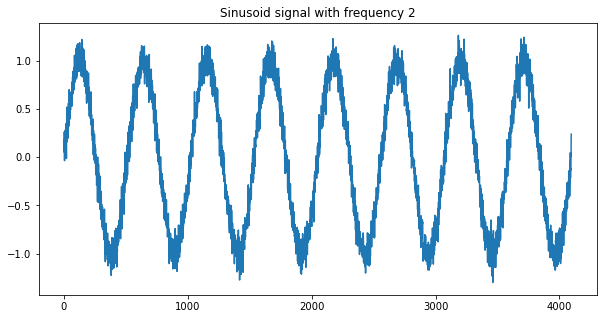

In [3]:
def generate_sinusoid_signal(T, f, fs=1024, seed=0):
    np.random.seed(seed)
    t = np.arange(T)
    x = np.sin(2 * np.pi * f * t / fs)

    # add white noise
    x += 0.1 * np.random.randn(T)
    return x


T = 2 ** 12
f = 2
fs = 1024

x = torch.from_numpy(generate_sinusoid_signal(T, f, fs)).float()
# x = torch.from_numpy(generate_harmonic_signal(T))

plt.figure(figsize=(10, 5))
plt.title(f'Sinusoid signal with frequency {f}')
plt.plot(x)
plt.show()

Text(0.5, 1.0, 'Spectrogram of original signal')

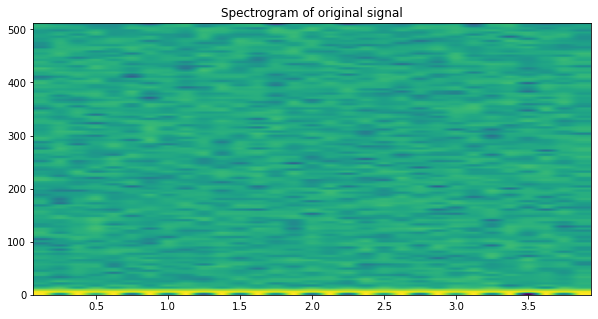

In [4]:
plt.figure(figsize=(10, 5))
plt.specgram(x.numpy(), Fs=fs)
plt.title("Spectrogram of original signal")

### Calculate scattering transform

In [5]:
J = 6
Q = 16

scattering = Scattering1D(J, T, Q).to(device)
x = x.to(device)

Sx = scattering(x)

learning_rate = 100
bold_driver_accelerator = 1.1
bold_driver_brake = 0.55
n_iterations = 200

### Reconstruct signal using gradient descent

Iteration   0, loss 4.62
Iteration  10, loss 0.56
Iteration  20, loss 0.18
Iteration  30, loss 0.14
Iteration  40, loss 0.11
Iteration  50, loss 0.10
Iteration  60, loss 0.09
Iteration  70, loss 0.15
Iteration  80, loss 0.07
Iteration  90, loss 0.06
Iteration 100, loss 0.08
Iteration 110, loss 0.06
Iteration 120, loss 0.06
Iteration 130, loss 0.06
Iteration 140, loss 0.06
Iteration 150, loss 0.06
Iteration 160, loss 0.06
Iteration 170, loss 0.06
Iteration 180, loss 0.06
Iteration 190, loss 0.06


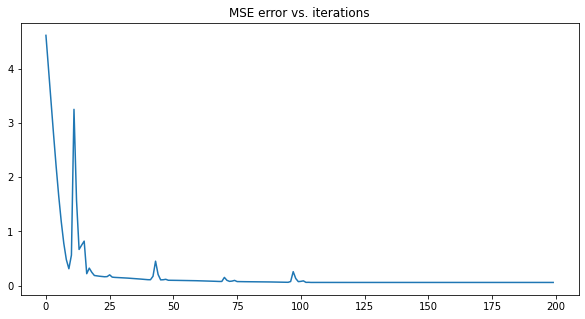

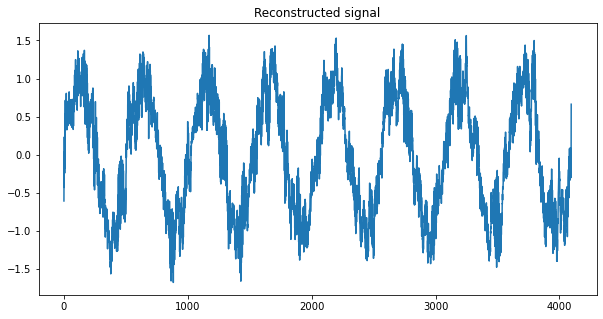

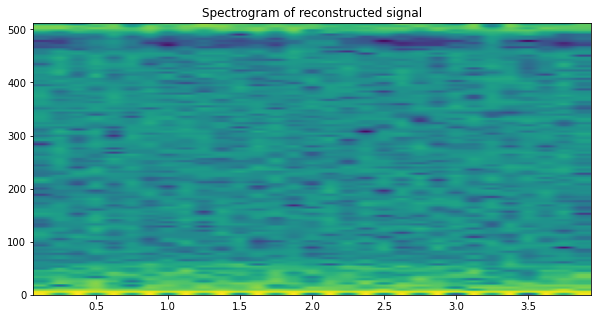

In [6]:
# Random guess to initialize.
torch.manual_seed(0)
y = torch.randn((T,), requires_grad=True, device=device)
Sy = scattering(y)

history = []
signal_update = torch.zeros_like(x, device=device)

# Iterate to recontsruct random guess to be close to target.
for k in range(n_iterations):
    # Backpropagation.
    err = torch.norm(Sx - Sy)

    if k % 10 == 0:
        print('Iteration %3d, loss %.2f' % (k, err.detach().cpu().numpy()))

    # Measure the new loss.
    history.append(err.detach().cpu())

    backward(err)

    delta_y = y.grad

    # Gradient descent
    with torch.no_grad():
        signal_update = - learning_rate * delta_y
        new_y = y + signal_update
    new_y.requires_grad = True

    # New forward propagation.
    Sy = scattering(new_y)

    if history[k] > history[k - 1]:
        learning_rate *= bold_driver_brake
    else:
        learning_rate *= bold_driver_accelerator
        y = new_y

plt.figure(figsize=(10, 5))
plt.plot(history)
plt.title("MSE error vs. iterations")

plt.figure(figsize=(10, 5))
plt.plot(y.detach().cpu().numpy())
plt.title("Reconstructed signal")

plt.figure(figsize=(10, 5))
plt.specgram(y.detach().cpu().numpy(), Fs=1024)
plt.title("Spectrogram of reconstructed signal")

plt.show()